## Introduction

<font color='gray'>This notebook was my submission to Kaggle's histopathology cancer detection competition with the aim to identify cancer metastasis in histopathological images taken from larger digital scans. The training dataset included ~220,000 images and the test dataset had ~58,000 images. I trained the model on an NVIDIA GTX 1060 GPU.</font>

### Import relevant libraries and the training labels

In [1]:
import tensorflow as tf
import keras
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import PIL


%matplotlib inline

Using TensorFlow backend.


In [2]:
labels = pd.read_csv("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train_labels.csv")

In [3]:
labels['label'].mean()

0.40503124644926713

### Visualize a few sample images
Reference: Joni Juvonen's __[kernel](https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai)__ on Kaggle 

In [19]:
def readImage(path):
    bgr_image = cv2.imread(path)
    b, g, r = cv2.split(bgr_image)
    rgb_image = cv2.merge([r, g, b])
    return rgb_image

In [4]:
train_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train"
val_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation"

Text(0, 0.5, 'Positive samples')

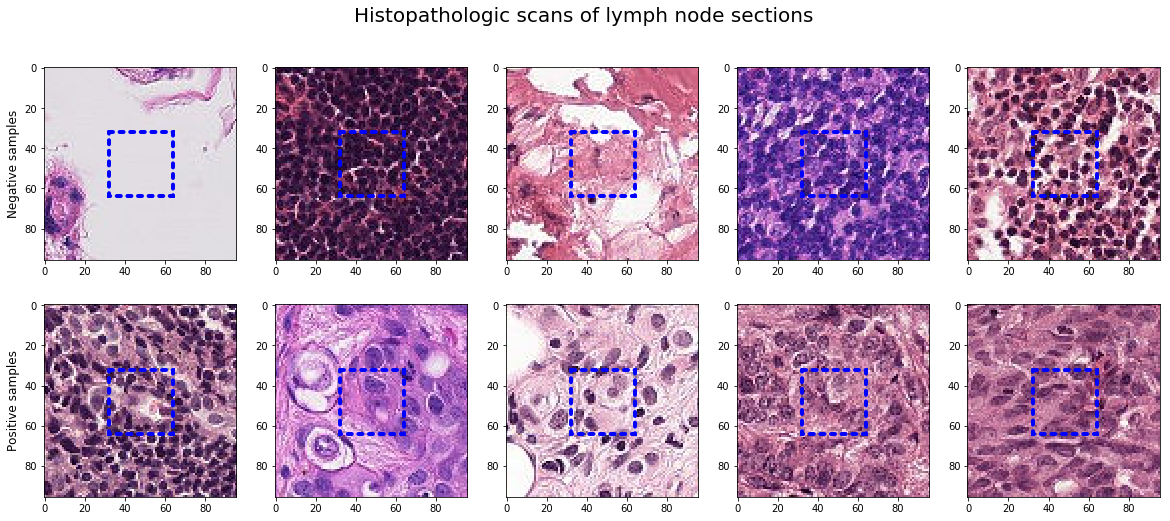

In [27]:
from sklearn.utils import shuffle
train_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train"
shuffled_data = shuffle(labels)

fig, ax = plt.subplots(2, 5, figsize = (20,8))
fig.suptitle("Histopathologic scans of lymph node sections", fontsize = 20)

for i, idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0, i].imshow(readImage(path + '.tif'))
    box = patches.Rectangle((32,32), 32, 32, edgecolor = 'b', linewidth = 4, 
                            facecolor = 'none', linestyle = ":", capstyle = 'round')
    ax[0, i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size = 'large')

for i , idx in enumerate(shuffled_data[shuffled_data['label']==1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1, i].imshow(readImage(path + '.tif'))
    box = patches.Rectangle((32,32), 32, 32, linewidth = 4, 
                            capstyle = 'round', edgecolor = 'b', facecolor ='none',linestyle = ":")
    ax[1, i].add_patch(box)
    
ax[1,0].set_ylabel('Positive samples', size = 'large')    
                      


### Distribute files to create training / validation folders with files in labelled folders for use in Keras training

In [29]:
os.mkdir("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation")

In [52]:
pos = shuffled_data.loc[shuffled_data['label']==1]
neg = shuffled_data.loc[shuffled_data['label']==0]

pos_train, pos_valid = train_test_split(list(pos['id']), test_size = 0.12)
neg_train, neg_valid = train_test_split(list(neg['id']), test_size = 0.12)

In [64]:
os.mkdir("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation\\pos")
os.mkdir("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation\\neg")
os.mkdir("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train\\pos")
os.mkdir("C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train\\neg")

In [59]:
for file in pos_valid:
    shutil.move(os.path.join(train_path, file) +'.tif', "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation\\pos")
for file in neg_valid:
    shutil.move(os.path.join(train_path, file) +'.tif', "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\validation\\neg")    

In [65]:
for file in pos_train:
    shutil.move(os.path.join(train_path, file) +'.tif', "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train\\pos")
for file in neg_train:
    shutil.move(os.path.join(train_path, file) +'.tif', "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\train\\neg")    

### Train DenseNet with data augmentation

In [5]:
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201, DenseNet169

In [7]:
base_model = DenseNet169(weights='imagenet', include_top=False, 
                         input_shape = (96, 96 ,3), pooling=None, input_tensor=None)


input_ = Input(shape=(96, 96, 3),name = 'image_input')
output_densenet = base_model(input_)

x = GlobalAveragePooling2D()(output_densenet)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(input = input_, outputs= x)
   
    
initial_learning_rate=0.00001
opt=keras.optimizers.adam(lr=initial_learning_rate, decay= 1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, 
              metrics=['binary_accuracy'])    


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\srini\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`
  # This is added back by InteractiveShellApp.init_path()


In [8]:
class_weights = {0:1., 1:1.5}
train_datagen = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=[1, 1.5], 
                                             width_shift_range=4,
                                             height_shift_range=4,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(96, 96),
        batch_size=64,
        class_mode='binary', shuffle = True)

validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(96, 96),
        batch_size=64,
        class_mode='binary')

Found 193621 images belonging to 2 classes.
Found 26404 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= len(train_generator.filenames)//64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.filenames)//64, callbacks= [EarlyStopping(patience=4), 
                           History(), 
                           ModelCheckpoint('weights.myCNN.18Mar19.densenet169.v1.{epoch:02d}.hdf5', 
                                           save_best_only = True, verbose = 2)],class_weight=class_weights)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3025/3025 [==============================] - 2201s 727ms/step - loss: 0.3568 - binary_accuracy: 0.8748 - val_loss: 0.2430 - val_binary_accuracy: 0.9057

Epoch 00001: val_loss improved from inf to 0.24297, saving model to weights.myCNN.18Mar19.densenet169.v1.01.hdf5
Epoch 2/30
3025/3025 [==============================] - 2060s 681ms/step - loss: 0.2441 - binary_accuracy: 0.9215 - val_loss: 0.1892 - val_binary_accuracy: 0.9278

Epoch 00002: val_loss improved from 0.24297 to 0.18918, saving model to weights.myCNN.18Mar19.densenet169.v1.02.hdf5
Epoch 3/30
3025/3025 [==============================] - 2004s 662ms/step - loss: 0.2062 - binary_accuracy: 0.9351 - val_loss: 0.1607 - val_binary_accuracy: 0.9403

Epoch 00003: val_loss improved from 0.18918 to 0.16069, saving model to weights.myCNN.18Mar19.densenet169.v1.03.hdf5
Epoch 4/30
3025/3025 [==============================] - 1994s 659ms/step - loss: 0.1807 - binary_accuracy: 0.9442

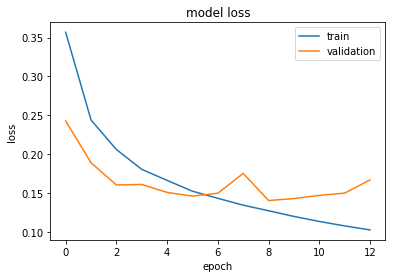

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [13]:
from keras.preprocessing.image import ImageDataGenerator
test_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\test_kaggle"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(96, 96),
        batch_size=128,
        class_mode=None, shuffle= False)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict_densenet = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/128), verbose=1)

Found 57458 images belonging to 1 classes.
449/449 [==============================] - 185s 412ms/step


In [14]:
test_filenames = []
for file in filenames:
    test_filenames.append(file[5:-4])

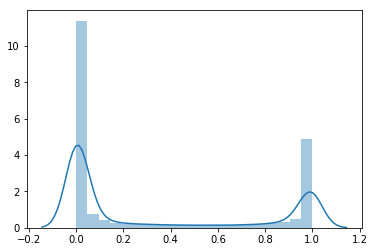

In [16]:
sns.distplot(predict_densenet)

In [23]:
test_submission_densenet = pd.DataFrame({'Id':test_filenames, 'label':np.squeeze(predict_densenet)})
test_submission_densenet.to_csv('submission_densenet_03092019.csv', index = False)

### AUC on test dataset uding only densenet 201 = 0.9362

## Prediction with test time augmentation (TTA) on DenseNet

In [13]:
model.load_weights('weights.myCNN.18Mar19.densenet169.v1.09.hdf5')
test_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\test_kaggle"
predictions_tta_densenet = []
for i in range(8):
    test_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, horizontal_flip=True, rotation_range=180,
                                     width_shift_range=4,
                                             height_shift_range=4,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

    test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=(96, 96),
            batch_size=128,
            class_mode=None, shuffle= False)

    filenames = test_generator.filenames
    nb_samples = len(filenames)
    test_filenames = []
    for file in filenames:
        test_filenames.append(file[5:-4])
    predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/128))
    predictions_tta_densenet.append(predict)
    
test_submission_densenet_tta = pd.DataFrame({'Id':test_filenames, 'label_d':
                                             np.squeeze(np.array(predictions_tta_densenet).mean(axis=0))})
test_submission_densenet_tta.to_csv('submission_densenet169_03182019_tta.csv', index = False)    

Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.


### AUC score = 0.9660. This is a significant improvement over the previous score without TTA

### <font color='green'> Train on second model using the Xception architecture for the ensemble </font>

In [95]:
base_model = Xception(weights='imagenet', include_top=False, 
                         input_shape = (96, 96 ,3), pooling=None, input_tensor=None)


input_ = Input(shape=(96, 96, 3),name = 'image_input')
output_xception = base_model(input_)

x = GlobalAveragePooling2D()(output_xception)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(input = input_, outputs= x)
   
    
initial_learning_rate=0.00001
opt = keras.optimizers.adam(lr=initial_learning_rate, decay= 1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, 
              metrics=['binary_accuracy'])    


C:\Users\srini\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`
  # This is added back by InteractiveShellApp.init_path()


In [24]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= len(train_generator.filenames)//64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=250, callbacks= [EarlyStopping(patience=4), 
                           History(), 
                           ModelCheckpoint('weights.myCNN.9Mar19.xception.v1.{epoch:02d}.hdf5', 
                                           save_best_only = True, verbose = 1)],class_weight=class_weights)

Epoch 1/30
3025/3025 [==============================] - 2075s 686ms/step - loss: 0.3498 - binary_accuracy: 0.8789 - val_loss: 0.2486 - val_binary_accuracy: 0.9043

Epoch 00001: val_loss improved from inf to 0.24859, saving model to weights.myCNN.9Mar19.xception.v1.01.hdf5
Epoch 2/30
3025/3025 [==============================] - 2078s 687ms/step - loss: 0.2941 - binary_accuracy: 0.9016 - val_loss: 0.2179 - val_binary_accuracy: 0.9169

Epoch 00002: val_loss improved from 0.24859 to 0.21787, saving model to weights.myCNN.9Mar19.xception.v1.02.hdf5
Epoch 3/30
3025/3025 [==============================] - 2073s 685ms/step - loss: 0.2647 - binary_accuracy: 0.9128 - val_loss: 0.1992 - val_binary_accuracy: 0.9261

Epoch 00003: val_loss improved from 0.21787 to 0.19924, saving model to weights.myCNN.9Mar19.xception.v1.03.hdf5
Epoch 4/30
3025/3025 [==============================] - 2082s 688ms/step - loss: 0.2432 - binary_accuracy: 0.9213 - val_loss: 0.1751 - val_binary_accuracy: 0.9329

Epoch 000

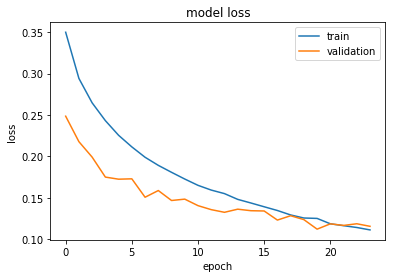

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Prediction on test data set without TTA

In [10]:
model.load_weights('weights.myCNN.9Mar19.xception.v1.20.hdf5')
from keras.preprocessing.image import ImageDataGenerator
test_path = "C:\\Users\\srini\\Data Science\\Kaggle_histopathology_March2019\\histopathologic-cancer-detection\\test_kaggle"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(96, 96),
        batch_size=128,
        class_mode=None, shuffle= False)

filenames = test_generator.filenames
nb_samples = len(filenames)

prediction_xception_1 = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/128))



Found 57458 images belonging to 1 classes.


In [17]:
test_filenames = []
for file in filenames:
    test_filenames.append(file[5:-4])

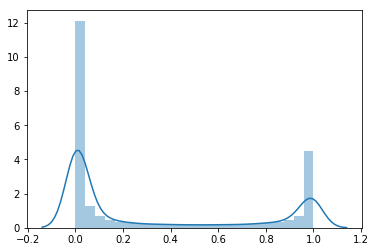

In [11]:
sns.distplot(prediction_xception_1)

In [18]:
test_submission_xception_notta = pd.DataFrame({'Id':test_filenames, 'label':np.squeeze(prediction_xception_1)})
test_submission_xception_notta.to_csv('submission_xception_03092019_without_tta.csv', index = False)

### AUC on test dataset uding only densenet 201 = 0.9309

### Prediction using TTA and the Xception model

In [96]:
model.load_weights('weights.myCNN.9Mar19.xception.v1.20.hdf5')
predictions_tta_xception = []
for i in range(10):
    test_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, horizontal_flip=True, rotation_range=180,
                                     width_shift_range=4,
                                             height_shift_range=4,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

    test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=(96, 96),
            batch_size=128,
            class_mode=None, shuffle= False)

    filenames = test_generator.filenames
    nb_samples = len(filenames)
    test_filenames = []
    for file in filenames:
        test_filenames.append(file[5:-4])
    predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/128))
    predictions_tta_xception.append(predict)

Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.
Found 57458 images belonging to 1 classes.


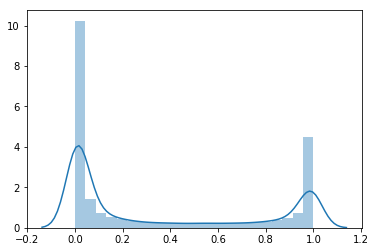

In [79]:
sns.distplot(np.squeeze(np.array(predictions_tta).mean(axis=0)))

In [97]:
test_submission_xception_tta = pd.DataFrame({'Id':test_filenames, 'label':np.squeeze(np.array(predictions_tta_xception).mean(axis=0))})
test_submission_xception_tta.to_csv('submission_xception_03172019_tta.csv', index = False)

### AUC Score on test set = 0.9631

### Create an ensemble prediction based on both models

In [16]:
test_submission_xception_tta = pd.read_csv('submission_xception_03172019_tta.csv')
test_submission_concat_tta = pd.concat([test_submission_xception_tta, test_submission_densenet_tta['label_d']], axis = 1)

In [17]:
test_submission_concat_tta['label_combined'] = 0.5*test_submission_concat_tta['label_d'] + 0.5*test_submission_concat_tta['label']

In [18]:
test_submission_concat_tta = test_submission_concat_tta.drop(['label_d','label'], axis=1)
test_submission_concat_tta = test_submission_concat_tta.rename(columns= {'label_combined':'label'})

In [19]:
test_submission_concat_tta.to_csv('submission_xception+densenet_tta_03182019.csv', index= False)

### AUC Score on test set = 0.9701